# Q-learning


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([ 0.0352074 , -0.16958948,  0.03418045,  0.31186796]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.5312159289647695 -2.737326851465852


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # returning the given data to the model
    return actions, states

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, # model input
               action_size, hidden_size): # model init for Qs
        
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
                                                                     labels=actions_onehot[1:]))
    
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
# from collections import deque

# class Memory():    
#     def __init__(self, max_size = 1000):
#         self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [24]:
# Training parameters
train_episodes = 10000         # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [25]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# # Init the memory
# memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [26]:
env.reset()

array([ 0.03683085,  0.01899471, -0.01706346,  0.00663042])

In [27]:
# # Initialize the simulation
# state = env.reset()
# batch = []

# # Make a bunch of random actions and store the experiences
# for each_step in range(max_steps):
    
#     # Take one random step to get the pole and cart moving
#     action = env.action_space.sample()
#     state, _, done, _ = env.step(action)
#     reward = 1 - float(done)
#     #memory.buffer.append((action, state, reward))
#     batch.append((action, state, reward))
    
#     # End of the episodes which defines the goal of the episode/mission
#     if done is True:
#         # Start new episode
#         #env.reset()
#         break

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [28]:
state, reward, action

(array([-0.17180266, -1.94207999,  0.22416418,  3.02408248]), 0.0, 0.0)

In [29]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Get action from model
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            action *= reward
            batch.append([action, state])
            if done is True:
                break
                
        #batch = memory.buffer
        actions = np.array([each[0] for each in batch])
        states = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                 model.states: states})
            
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(len(batch)),
              'Batch loss: {:.9f}'.format(loss))
        print('-------------------------------------------------------------------------------')
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 9 Batch loss: 0.613494158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 10 Batch loss: 0.553664207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 10 Batch loss: 0.512427330
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 9 Batch loss: 0.485959113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4 Total reward: 10 Batch loss: 0.437298805
----------------------

-------------------------------------------------------------------------------
Episode: 39 Total reward: 9 Batch loss: 0.034216557
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 40 Total reward: 9 Batch loss: 0.030557975
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 41 Total reward: 9 Batch loss: 0.028396949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 42 Total reward: 10 Batch loss: 0.025614524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 43 Total reward: 9 Batch loss: 0.023965035
-------------------

-------------------------------------------------------------------------------
Episode: 78 Total reward: 9 Batch loss: 0.004959823
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 79 Total reward: 10 Batch loss: 0.005321264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 80 Total reward: 10 Batch loss: 0.004536381
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 81 Total reward: 9 Batch loss: 0.004528984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 82 Total reward: 8 Batch loss: 0.005257945
------------------

-------------------------------------------------------------------------------
Episode: 119 Total reward: 9 Batch loss: 0.001535012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 120 Total reward: 8 Batch loss: 0.001586366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 121 Total reward: 10 Batch loss: 0.001482642
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 122 Total reward: 10 Batch loss: 0.001575930
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 123 Total reward: 9 Batch loss: 0.001704808
-------------

-------------------------------------------------------------------------------
Episode: 160 Total reward: 10 Batch loss: 0.000687211
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 161 Total reward: 9 Batch loss: 0.000705795
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 10 Batch loss: 0.000749376
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 9 Batch loss: 0.000794658
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 9 Batch loss: 0.000733920
-------------

-------------------------------------------------------------------------------
Episode: 199 Total reward: 10 Batch loss: 0.000448697
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 9 Batch loss: 0.000375521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 9 Batch loss: 0.000484845
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 9 Batch loss: 0.000411034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 8 Batch loss: 0.000468799
--------------

-------------------------------------------------------------------------------
Episode: 238 Total reward: 9 Batch loss: 0.000279036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 239 Total reward: 9 Batch loss: 0.000247695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 240 Total reward: 9 Batch loss: 0.000337386
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 241 Total reward: 10 Batch loss: 0.000345427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 242 Total reward: 9 Batch loss: 0.000261018
--------------

-------------------------------------------------------------------------------
Episode: 279 Total reward: 9 Batch loss: 0.000207672
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 10 Batch loss: 0.000240771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 281 Total reward: 9 Batch loss: 0.000246771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 282 Total reward: 8 Batch loss: 0.000234597
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 283 Total reward: 10 Batch loss: 0.000157921
-------------

-------------------------------------------------------------------------------
Episode: 319 Total reward: 8 Batch loss: 0.000130239
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 320 Total reward: 9 Batch loss: 0.000118055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 321 Total reward: 10 Batch loss: 0.000150800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 322 Total reward: 10 Batch loss: 0.000133767
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 323 Total reward: 9 Batch loss: 0.000155668
-------------

-------------------------------------------------------------------------------
Episode: 359 Total reward: 9 Batch loss: 0.000128285
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 360 Total reward: 10 Batch loss: 0.000116321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 10 Batch loss: 0.000115448
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 362 Total reward: 10 Batch loss: 0.000127611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 10 Batch loss: 0.000087265
-----------

-------------------------------------------------------------------------------
Episode: 400 Total reward: 8 Batch loss: 0.000098205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 10 Batch loss: 0.000101946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total reward: 9 Batch loss: 0.000078617
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 403 Total reward: 10 Batch loss: 0.000075972
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 404 Total reward: 9 Batch loss: 0.000104383
-------------

-------------------------------------------------------------------------------
Episode: 441 Total reward: 10 Batch loss: 0.000081810
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 442 Total reward: 9 Batch loss: 0.000072048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 443 Total reward: 10 Batch loss: 0.000051729
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 444 Total reward: 9 Batch loss: 0.000073716
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 445 Total reward: 9 Batch loss: 0.000060325
-------------

-------------------------------------------------------------------------------
Episode: 480 Total reward: 10 Batch loss: 0.000066399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 481 Total reward: 8 Batch loss: 0.000046265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 482 Total reward: 10 Batch loss: 0.000054562
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 483 Total reward: 8 Batch loss: 0.000053348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 484 Total reward: 9 Batch loss: 0.000049897
-------------

-------------------------------------------------------------------------------
Episode: 522 Total reward: 10 Batch loss: 0.000042923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 523 Total reward: 9 Batch loss: 0.000041331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 524 Total reward: 9 Batch loss: 0.000039811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 525 Total reward: 9 Batch loss: 0.000040780
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 526 Total reward: 10 Batch loss: 0.000048524
-------------

-------------------------------------------------------------------------------
Episode: 563 Total reward: 9 Batch loss: 0.000035327
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 564 Total reward: 10 Batch loss: 0.000034713
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 565 Total reward: 9 Batch loss: 0.000047096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 566 Total reward: 10 Batch loss: 0.000034620
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 10 Batch loss: 0.000041453
------------

-------------------------------------------------------------------------------
Episode: 606 Total reward: 10 Batch loss: 0.000035904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 607 Total reward: 9 Batch loss: 0.000027610
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 608 Total reward: 9 Batch loss: 0.000027803
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 609 Total reward: 9 Batch loss: 0.000035089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 610 Total reward: 10 Batch loss: 0.000036831
-------------

-------------------------------------------------------------------------------
Episode: 647 Total reward: 9 Batch loss: 0.000024302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 648 Total reward: 9 Batch loss: 0.000032243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 649 Total reward: 8 Batch loss: 0.000023653
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 650 Total reward: 11 Batch loss: 0.000024221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 9 Batch loss: 0.000028489
--------------

-------------------------------------------------------------------------------
Episode: 691 Total reward: 10 Batch loss: 0.000021774
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 692 Total reward: 8 Batch loss: 0.000021082
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 9 Batch loss: 0.000031513
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 8 Batch loss: 0.000023874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 695 Total reward: 11 Batch loss: 0.000025675
-------------

-------------------------------------------------------------------------------
Episode: 733 Total reward: 9 Batch loss: 0.000018521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 10 Batch loss: 0.000015232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 10 Batch loss: 0.000016079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 Total reward: 10 Batch loss: 0.000023138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 737 Total reward: 10 Batch loss: 0.000018437
-----------

-------------------------------------------------------------------------------
Episode: 774 Total reward: 10 Batch loss: 0.000020489
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 775 Total reward: 8 Batch loss: 0.000014764
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 776 Total reward: 9 Batch loss: 0.000019773
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 777 Total reward: 9 Batch loss: 0.000022216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 778 Total reward: 9 Batch loss: 0.000021307
--------------

-------------------------------------------------------------------------------
Episode: 816 Total reward: 10 Batch loss: 0.000015457
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 10 Batch loss: 0.000015205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 818 Total reward: 11 Batch loss: 0.000017809
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 10 Batch loss: 0.000020701
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 820 Total reward: 10 Batch loss: 0.000019099
----------

-------------------------------------------------------------------------------
Episode: 857 Total reward: 11 Batch loss: 0.000016140
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 858 Total reward: 8 Batch loss: 0.000012704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 859 Total reward: 9 Batch loss: 0.000014439
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 860 Total reward: 9 Batch loss: 0.000019236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 861 Total reward: 9 Batch loss: 0.000014021
--------------

-------------------------------------------------------------------------------
Episode: 897 Total reward: 10 Batch loss: 0.000013841
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 898 Total reward: 9 Batch loss: 0.000011965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 899 Total reward: 10 Batch loss: 0.000013033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 900 Total reward: 9 Batch loss: 0.000014096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 10 Batch loss: 0.000011298
------------

-------------------------------------------------------------------------------
Episode: 938 Total reward: 9 Batch loss: 0.000016688
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 939 Total reward: 10 Batch loss: 0.000015761
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 940 Total reward: 10 Batch loss: 0.000012358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 941 Total reward: 8 Batch loss: 0.000009145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 942 Total reward: 9 Batch loss: 0.000011324
-------------

-------------------------------------------------------------------------------
Episode: 980 Total reward: 10 Batch loss: 0.000010689
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 981 Total reward: 10 Batch loss: 0.000011391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 982 Total reward: 9 Batch loss: 0.000010877
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 983 Total reward: 10 Batch loss: 0.000011391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 984 Total reward: 9 Batch loss: 0.000010848
------------

-------------------------------------------------------------------------------
Episode: 1022 Total reward: 9 Batch loss: 0.000009924
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1023 Total reward: 8 Batch loss: 0.000007289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1024 Total reward: 10 Batch loss: 0.000011735
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1025 Total reward: 9 Batch loss: 0.000009894
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1026 Total reward: 9 Batch loss: 0.000008836
---------

-------------------------------------------------------------------------------
Episode: 1063 Total reward: 10 Batch loss: 0.000006927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1064 Total reward: 9 Batch loss: 0.000008389
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1065 Total reward: 9 Batch loss: 0.000008330
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1066 Total reward: 9 Batch loss: 0.000006914
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1067 Total reward: 10 Batch loss: 0.000007907
--------

-------------------------------------------------------------------------------
Episode: 1103 Total reward: 10 Batch loss: 0.000006993
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1104 Total reward: 10 Batch loss: 0.000006543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1105 Total reward: 9 Batch loss: 0.000006959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1106 Total reward: 9 Batch loss: 0.000009387
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1107 Total reward: 9 Batch loss: 0.000009224
--------

-------------------------------------------------------------------------------
Episode: 1144 Total reward: 10 Batch loss: 0.000007364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1145 Total reward: 9 Batch loss: 0.000008166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1146 Total reward: 9 Batch loss: 0.000005633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1147 Total reward: 10 Batch loss: 0.000007868
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1148 Total reward: 9 Batch loss: 0.000008076
--------

-------------------------------------------------------------------------------
Episode: 1185 Total reward: 8 Batch loss: 0.000006522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1186 Total reward: 9 Batch loss: 0.000008002
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1187 Total reward: 10 Batch loss: 0.000005854
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1188 Total reward: 10 Batch loss: 0.000006848
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1189 Total reward: 9 Batch loss: 0.000007540
--------

-------------------------------------------------------------------------------
Episode: 1227 Total reward: 8 Batch loss: 0.000006267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1228 Total reward: 9 Batch loss: 0.000006676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1229 Total reward: 10 Batch loss: 0.000007073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1230 Total reward: 10 Batch loss: 0.000005298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1231 Total reward: 9 Batch loss: 0.000008181
--------

Episode: 1267 Total reward: 10 Batch loss: 0.000005934
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1268 Total reward: 9 Batch loss: 0.000004932
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1269 Total reward: 8 Batch loss: 0.000004785
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1270 Total reward: 11 Batch loss: 0.000007689
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1271 Total reward: 9 Batch loss: 0.000006169
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 1307 Total reward: 10 Batch loss: 0.000005762
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1308 Total reward: 9 Batch loss: 0.000005588
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1309 Total reward: 10 Batch loss: 0.000007364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1310 Total reward: 10 Batch loss: 0.000004278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1311 Total reward: 9 Batch loss: 0.000005692
-------

-------------------------------------------------------------------------------
Episode: 1349 Total reward: 9 Batch loss: 0.000003546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1350 Total reward: 10 Batch loss: 0.000005470
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1351 Total reward: 9 Batch loss: 0.000005454
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1352 Total reward: 9 Batch loss: 0.000004291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1353 Total reward: 10 Batch loss: 0.000004835
--------

-------------------------------------------------------------------------------
Episode: 1390 Total reward: 10 Batch loss: 0.000003735
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1391 Total reward: 10 Batch loss: 0.000005391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1392 Total reward: 10 Batch loss: 0.000006199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1393 Total reward: 10 Batch loss: 0.000003748
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1394 Total reward: 9 Batch loss: 0.000005037
------

-------------------------------------------------------------------------------
Episode: 1430 Total reward: 10 Batch loss: 0.000003921
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1431 Total reward: 10 Batch loss: 0.000004914
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1432 Total reward: 9 Batch loss: 0.000004291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1433 Total reward: 9 Batch loss: 0.000005230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1434 Total reward: 8 Batch loss: 0.000004138
--------

-------------------------------------------------------------------------------
Episode: 1471 Total reward: 10 Batch loss: 0.000004238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1472 Total reward: 8 Batch loss: 0.000005977
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1473 Total reward: 10 Batch loss: 0.000002861
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1474 Total reward: 9 Batch loss: 0.000003800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1475 Total reward: 10 Batch loss: 0.000004782
-------

-------------------------------------------------------------------------------
Episode: 1512 Total reward: 10 Batch loss: 0.000004662
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1513 Total reward: 9 Batch loss: 0.000004306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1514 Total reward: 9 Batch loss: 0.000002697
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1515 Total reward: 9 Batch loss: 0.000003770
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1516 Total reward: 9 Batch loss: 0.000004157
---------

-------------------------------------------------------------------------------
Episode: 1554 Total reward: 10 Batch loss: 0.000004662
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1555 Total reward: 9 Batch loss: 0.000002936
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1556 Total reward: 10 Batch loss: 0.000004225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1557 Total reward: 9 Batch loss: 0.000003248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1558 Total reward: 10 Batch loss: 0.000003682
-------

-------------------------------------------------------------------------------
Episode: 1595 Total reward: 10 Batch loss: 0.000004344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1596 Total reward: 9 Batch loss: 0.000003129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1597 Total reward: 9 Batch loss: 0.000003248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1598 Total reward: 10 Batch loss: 0.000003311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1599 Total reward: 9 Batch loss: 0.000003666
--------

-------------------------------------------------------------------------------
Episode: 1636 Total reward: 9 Batch loss: 0.000004083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1637 Total reward: 10 Batch loss: 0.000002291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1638 Total reward: 9 Batch loss: 0.000002757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 9 Batch loss: 0.000004128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1640 Total reward: 8 Batch loss: 0.000002623
---------

-------------------------------------------------------------------------------
Episode: 1678 Total reward: 10 Batch loss: 0.000003629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1679 Total reward: 9 Batch loss: 0.000002518
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1680 Total reward: 10 Batch loss: 0.000003709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1681 Total reward: 8 Batch loss: 0.000003031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1682 Total reward: 10 Batch loss: 0.000002225
-------

-------------------------------------------------------------------------------
Episode: 1721 Total reward: 10 Batch loss: 0.000003722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1722 Total reward: 10 Batch loss: 0.000003311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1723 Total reward: 9 Batch loss: 0.000002027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1724 Total reward: 10 Batch loss: 0.000001881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1725 Total reward: 9 Batch loss: 0.000002563
-------

-------------------------------------------------------------------------------
Episode: 1765 Total reward: 8 Batch loss: 0.000002929
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1766 Total reward: 8 Batch loss: 0.000003287
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1767 Total reward: 10 Batch loss: 0.000003775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1768 Total reward: 10 Batch loss: 0.000002450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1769 Total reward: 8 Batch loss: 0.000002486
--------

-------------------------------------------------------------------------------
Episode: 1806 Total reward: 10 Batch loss: 0.000002821
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1807 Total reward: 10 Batch loss: 0.000002874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1808 Total reward: 11 Batch loss: 0.000002360
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1809 Total reward: 8 Batch loss: 0.000002623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1810 Total reward: 10 Batch loss: 0.000002503
------

-------------------------------------------------------------------------------
Episode: 1847 Total reward: 9 Batch loss: 0.000002086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1848 Total reward: 10 Batch loss: 0.000002291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1849 Total reward: 10 Batch loss: 0.000002901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1850 Total reward: 10 Batch loss: 0.000002027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1851 Total reward: 9 Batch loss: 0.000002772
-------

-------------------------------------------------------------------------------
Episode: 1890 Total reward: 10 Batch loss: 0.000001947
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1891 Total reward: 10 Batch loss: 0.000002119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1892 Total reward: 8 Batch loss: 0.000001771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1893 Total reward: 11 Batch loss: 0.000002086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1894 Total reward: 11 Batch loss: 0.000002718
------

-------------------------------------------------------------------------------
Episode: 1932 Total reward: 10 Batch loss: 0.000002411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1933 Total reward: 9 Batch loss: 0.000002578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1934 Total reward: 10 Batch loss: 0.000002583
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1935 Total reward: 8 Batch loss: 0.000001737
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1936 Total reward: 9 Batch loss: 0.000002235
--------

-------------------------------------------------------------------------------
Episode: 1972 Total reward: 8 Batch loss: 0.000002623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1973 Total reward: 9 Batch loss: 0.000001997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1974 Total reward: 9 Batch loss: 0.000001848
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1975 Total reward: 10 Batch loss: 0.000001589
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1976 Total reward: 9 Batch loss: 0.000001594
---------

-------------------------------------------------------------------------------
Episode: 2016 Total reward: 9 Batch loss: 0.000001431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2017 Total reward: 10 Batch loss: 0.000002676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2018 Total reward: 10 Batch loss: 0.000001868
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2019 Total reward: 9 Batch loss: 0.000002518
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2020 Total reward: 10 Batch loss: 0.000002159
-------

-------------------------------------------------------------------------------
Episode: 2058 Total reward: 10 Batch loss: 0.000001934
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2059 Total reward: 10 Batch loss: 0.000002119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2060 Total reward: 9 Batch loss: 0.000001833
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2061 Total reward: 10 Batch loss: 0.000002106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2062 Total reward: 10 Batch loss: 0.000001788
------

Episode: 2099 Total reward: 9 Batch loss: 0.000001162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2100 Total reward: 9 Batch loss: 0.000001639
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2101 Total reward: 10 Batch loss: 0.000002185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2102 Total reward: 9 Batch loss: 0.000001818
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2103 Total reward: 9 Batch loss: 0.000001848
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 2139 Total reward: 10 Batch loss: 0.000001258
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2140 Total reward: 10 Batch loss: 0.000002000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2141 Total reward: 8 Batch loss: 0.000002214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2142 Total reward: 10 Batch loss: 0.000001775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2143 Total reward: 9 Batch loss: 0.000001490
-------

-------------------------------------------------------------------------------
Episode: 2182 Total reward: 10 Batch loss: 0.000001669
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2183 Total reward: 10 Batch loss: 0.000002133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2184 Total reward: 8 Batch loss: 0.000001243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2185 Total reward: 9 Batch loss: 0.000001967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2186 Total reward: 10 Batch loss: 0.000001470
-------

-------------------------------------------------------------------------------
Episode: 2225 Total reward: 10 Batch loss: 0.000001417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2226 Total reward: 8 Batch loss: 0.000001635
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2227 Total reward: 10 Batch loss: 0.000001179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2228 Total reward: 10 Batch loss: 0.000001060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2229 Total reward: 8 Batch loss: 0.000002027
-------

-------------------------------------------------------------------------------
Episode: 2269 Total reward: 9 Batch loss: 0.000001401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2270 Total reward: 9 Batch loss: 0.000001296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2271 Total reward: 8 Batch loss: 0.000001158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2272 Total reward: 9 Batch loss: 0.000001639
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2273 Total reward: 10 Batch loss: 0.000001801
---------

-------------------------------------------------------------------------------
Episode: 2312 Total reward: 8 Batch loss: 0.000001635
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2313 Total reward: 8 Batch loss: 0.000001379
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2314 Total reward: 10 Batch loss: 0.000001298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2315 Total reward: 10 Batch loss: 0.000001709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2316 Total reward: 9 Batch loss: 0.000001624
--------

-------------------------------------------------------------------------------
Episode: 2352 Total reward: 10 Batch loss: 0.000001444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2353 Total reward: 8 Batch loss: 0.000000937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2354 Total reward: 10 Batch loss: 0.000001788
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2355 Total reward: 9 Batch loss: 0.000001088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2356 Total reward: 10 Batch loss: 0.000001205
-------

-------------------------------------------------------------------------------
Episode: 2393 Total reward: 9 Batch loss: 0.000001684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2394 Total reward: 10 Batch loss: 0.000001444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2395 Total reward: 10 Batch loss: 0.000000967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2396 Total reward: 10 Batch loss: 0.000001497
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2397 Total reward: 10 Batch loss: 0.000001378
------

-------------------------------------------------------------------------------
Episode: 2433 Total reward: 10 Batch loss: 0.000001364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2434 Total reward: 9 Batch loss: 0.000001252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2435 Total reward: 9 Batch loss: 0.000001073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2436 Total reward: 9 Batch loss: 0.000000983
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2437 Total reward: 10 Batch loss: 0.000001629
--------

-------------------------------------------------------------------------------
Episode: 2476 Total reward: 9 Batch loss: 0.000000939
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2477 Total reward: 9 Batch loss: 0.000001460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2478 Total reward: 10 Batch loss: 0.000001086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2479 Total reward: 8 Batch loss: 0.000001124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2480 Total reward: 9 Batch loss: 0.000001416
---------

-------------------------------------------------------------------------------
Episode: 2518 Total reward: 10 Batch loss: 0.000000808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2519 Total reward: 10 Batch loss: 0.000000980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2520 Total reward: 11 Batch loss: 0.000001538
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2521 Total reward: 9 Batch loss: 0.000001222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2522 Total reward: 10 Batch loss: 0.000001113
------

-------------------------------------------------------------------------------
Episode: 2559 Total reward: 9 Batch loss: 0.000001222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2560 Total reward: 10 Batch loss: 0.000000980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2561 Total reward: 10 Batch loss: 0.000001139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2562 Total reward: 9 Batch loss: 0.000001043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2563 Total reward: 9 Batch loss: 0.000000626
--------

-------------------------------------------------------------------------------
Episode: 2602 Total reward: 10 Batch loss: 0.000000821
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2603 Total reward: 10 Batch loss: 0.000001311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2604 Total reward: 8 Batch loss: 0.000000903
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2605 Total reward: 10 Batch loss: 0.000001391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2606 Total reward: 9 Batch loss: 0.000000969
-------

-------------------------------------------------------------------------------
Episode: 2643 Total reward: 9 Batch loss: 0.000000864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2644 Total reward: 10 Batch loss: 0.000000649
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2645 Total reward: 9 Batch loss: 0.000000745
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2646 Total reward: 9 Batch loss: 0.000000656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2647 Total reward: 9 Batch loss: 0.000001028
---------

-------------------------------------------------------------------------------
Episode: 2685 Total reward: 9 Batch loss: 0.000000864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2686 Total reward: 9 Batch loss: 0.000001028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2687 Total reward: 11 Batch loss: 0.000000811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2688 Total reward: 9 Batch loss: 0.000000864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2689 Total reward: 10 Batch loss: 0.000000993
--------

-------------------------------------------------------------------------------
Episode: 2725 Total reward: 9 Batch loss: 0.000000685
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2726 Total reward: 9 Batch loss: 0.000001103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2727 Total reward: 10 Batch loss: 0.000001113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2728 Total reward: 8 Batch loss: 0.000000937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2729 Total reward: 8 Batch loss: 0.000001039
---------

-------------------------------------------------------------------------------
Episode: 2766 Total reward: 10 Batch loss: 0.000000755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2767 Total reward: 9 Batch loss: 0.000001073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2768 Total reward: 9 Batch loss: 0.000000864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2769 Total reward: 8 Batch loss: 0.000001022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2770 Total reward: 9 Batch loss: 0.000000894
---------

-------------------------------------------------------------------------------
Episode: 2809 Total reward: 9 Batch loss: 0.000000983
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2810 Total reward: 10 Batch loss: 0.000000834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2811 Total reward: 9 Batch loss: 0.000000924
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2812 Total reward: 9 Batch loss: 0.000000656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2813 Total reward: 9 Batch loss: 0.000000656
---------

-------------------------------------------------------------------------------
Episode: 2854 Total reward: 10 Batch loss: 0.000000490
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2855 Total reward: 8 Batch loss: 0.000000528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2856 Total reward: 9 Batch loss: 0.000000790
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2857 Total reward: 9 Batch loss: 0.000000849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2858 Total reward: 8 Batch loss: 0.000000647
---------

-------------------------------------------------------------------------------
Episode: 2899 Total reward: 8 Batch loss: 0.000000545
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2900 Total reward: 8 Batch loss: 0.000001090
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2901 Total reward: 9 Batch loss: 0.000000864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2902 Total reward: 8 Batch loss: 0.000000596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2903 Total reward: 10 Batch loss: 0.000000795
---------

-------------------------------------------------------------------------------
Episode: 2942 Total reward: 10 Batch loss: 0.000000861
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2943 Total reward: 10 Batch loss: 0.000001099
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2944 Total reward: 10 Batch loss: 0.000000676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2945 Total reward: 8 Batch loss: 0.000000562
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2946 Total reward: 10 Batch loss: 0.000000861
------

-------------------------------------------------------------------------------
Episode: 2984 Total reward: 10 Batch loss: 0.000000781
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2985 Total reward: 9 Batch loss: 0.000000432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2986 Total reward: 9 Batch loss: 0.000000671
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2987 Total reward: 10 Batch loss: 0.000000821
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2988 Total reward: 8 Batch loss: 0.000001022
--------

-------------------------------------------------------------------------------
Episode: 3026 Total reward: 9 Batch loss: 0.000000775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3027 Total reward: 10 Batch loss: 0.000000477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3028 Total reward: 9 Batch loss: 0.000000566
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3029 Total reward: 9 Batch loss: 0.000000864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3030 Total reward: 10 Batch loss: 0.000000583
--------

-------------------------------------------------------------------------------
Episode: 3066 Total reward: 8 Batch loss: 0.000000681
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3067 Total reward: 10 Batch loss: 0.000000676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3068 Total reward: 10 Batch loss: 0.000000742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3069 Total reward: 9 Batch loss: 0.000000522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3070 Total reward: 10 Batch loss: 0.000000543
-------

-------------------------------------------------------------------------------
Episode: 3109 Total reward: 10 Batch loss: 0.000000728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3110 Total reward: 10 Batch loss: 0.000000662
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3111 Total reward: 9 Batch loss: 0.000000522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3112 Total reward: 10 Batch loss: 0.000000676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3113 Total reward: 8 Batch loss: 0.000000579
-------

-------------------------------------------------------------------------------
Episode: 3150 Total reward: 9 Batch loss: 0.000000492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3151 Total reward: 10 Batch loss: 0.000000623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3152 Total reward: 9 Batch loss: 0.000000507
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3153 Total reward: 10 Batch loss: 0.000000781
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3154 Total reward: 9 Batch loss: 0.000000387
--------

-------------------------------------------------------------------------------
Episode: 3192 Total reward: 9 Batch loss: 0.000000492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3193 Total reward: 10 Batch loss: 0.000000358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3194 Total reward: 10 Batch loss: 0.000000477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3195 Total reward: 9 Batch loss: 0.000000373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3196 Total reward: 8 Batch loss: 0.000000494
--------

-------------------------------------------------------------------------------
Episode: 3234 Total reward: 9 Batch loss: 0.000000551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3235 Total reward: 10 Batch loss: 0.000000689
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3236 Total reward: 8 Batch loss: 0.000000494
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3237 Total reward: 11 Batch loss: 0.000000751
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3238 Total reward: 10 Batch loss: 0.000000715
-------

-------------------------------------------------------------------------------
Episode: 3276 Total reward: 10 Batch loss: 0.000000728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3277 Total reward: 10 Batch loss: 0.000000662
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3278 Total reward: 9 Batch loss: 0.000000566
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3279 Total reward: 10 Batch loss: 0.000000570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3280 Total reward: 10 Batch loss: 0.000000570
------

-------------------------------------------------------------------------------
Episode: 3316 Total reward: 10 Batch loss: 0.000000450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3317 Total reward: 11 Batch loss: 0.000000644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3318 Total reward: 9 Batch loss: 0.000000492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3319 Total reward: 10 Batch loss: 0.000000689
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3320 Total reward: 10 Batch loss: 0.000000543
------

-------------------------------------------------------------------------------
Episode: 3359 Total reward: 10 Batch loss: 0.000000344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3360 Total reward: 10 Batch loss: 0.000000676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3361 Total reward: 10 Batch loss: 0.000000358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3362 Total reward: 10 Batch loss: 0.000000596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3363 Total reward: 9 Batch loss: 0.000000328
------

-------------------------------------------------------------------------------
Episode: 3401 Total reward: 10 Batch loss: 0.000000609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3402 Total reward: 10 Batch loss: 0.000000424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3403 Total reward: 10 Batch loss: 0.000000450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3404 Total reward: 9 Batch loss: 0.000000417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3405 Total reward: 10 Batch loss: 0.000000517
------

-------------------------------------------------------------------------------
Episode: 3440 Total reward: 10 Batch loss: 0.000000543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3441 Total reward: 10 Batch loss: 0.000000437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3442 Total reward: 9 Batch loss: 0.000000417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3443 Total reward: 9 Batch loss: 0.000000492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3444 Total reward: 10 Batch loss: 0.000000331
-------

-------------------------------------------------------------------------------
Episode: 3482 Total reward: 9 Batch loss: 0.000000328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3483 Total reward: 10 Batch loss: 0.000000503
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3484 Total reward: 11 Batch loss: 0.000000417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3485 Total reward: 9 Batch loss: 0.000000358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3486 Total reward: 8 Batch loss: 0.000000375
--------

-------------------------------------------------------------------------------
Episode: 3522 Total reward: 9 Batch loss: 0.000000522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3523 Total reward: 10 Batch loss: 0.000000397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3524 Total reward: 10 Batch loss: 0.000000490
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3525 Total reward: 10 Batch loss: 0.000000477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3526 Total reward: 9 Batch loss: 0.000000507
-------

-------------------------------------------------------------------------------
Episode: 3563 Total reward: 9 Batch loss: 0.000000417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3564 Total reward: 9 Batch loss: 0.000000402
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3565 Total reward: 10 Batch loss: 0.000000411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3566 Total reward: 8 Batch loss: 0.000000272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3567 Total reward: 9 Batch loss: 0.000000343
---------

-------------------------------------------------------------------------------
Episode: 3604 Total reward: 10 Batch loss: 0.000000450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3605 Total reward: 10 Batch loss: 0.000000384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3606 Total reward: 10 Batch loss: 0.000000291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3607 Total reward: 8 Batch loss: 0.000000307
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3608 Total reward: 9 Batch loss: 0.000000417
-------

-------------------------------------------------------------------------------
Episode: 3643 Total reward: 9 Batch loss: 0.000000477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3644 Total reward: 8 Batch loss: 0.000000341
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3645 Total reward: 9 Batch loss: 0.000000298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3646 Total reward: 10 Batch loss: 0.000000384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3647 Total reward: 9 Batch loss: 0.000000238
---------

-------------------------------------------------------------------------------
Episode: 3686 Total reward: 10 Batch loss: 0.000000424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3687 Total reward: 9 Batch loss: 0.000000373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3688 Total reward: 9 Batch loss: 0.000000283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3689 Total reward: 10 Batch loss: 0.000000490
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3690 Total reward: 10 Batch loss: 0.000000384
-------

-------------------------------------------------------------------------------
Episode: 3730 Total reward: 10 Batch loss: 0.000000437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3731 Total reward: 8 Batch loss: 0.000000307
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3732 Total reward: 10 Batch loss: 0.000000437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3733 Total reward: 10 Batch loss: 0.000000411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3734 Total reward: 9 Batch loss: 0.000000268
-------

-------------------------------------------------------------------------------
Episode: 3769 Total reward: 8 Batch loss: 0.000000409
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3770 Total reward: 11 Batch loss: 0.000000310
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3771 Total reward: 10 Batch loss: 0.000000477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3772 Total reward: 11 Batch loss: 0.000000536
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3773 Total reward: 10 Batch loss: 0.000000358
------

-------------------------------------------------------------------------------
Episode: 3812 Total reward: 9 Batch loss: 0.000000298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3813 Total reward: 10 Batch loss: 0.000000305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3814 Total reward: 10 Batch loss: 0.000000318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3815 Total reward: 8 Batch loss: 0.000000409
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3816 Total reward: 10 Batch loss: 0.000000331
-------

-------------------------------------------------------------------------------
Episode: 3854 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3855 Total reward: 8 Batch loss: 0.000000375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3856 Total reward: 10 Batch loss: 0.000000291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3857 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3858 Total reward: 11 Batch loss: 0.000000370
-------

-------------------------------------------------------------------------------
Episode: 3894 Total reward: 10 Batch loss: 0.000000437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3895 Total reward: 10 Batch loss: 0.000000265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3896 Total reward: 11 Batch loss: 0.000000310
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3897 Total reward: 10 Batch loss: 0.000000305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3898 Total reward: 9 Batch loss: 0.000000313
------

-------------------------------------------------------------------------------
Episode: 3935 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3936 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3937 Total reward: 10 Batch loss: 0.000000371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3938 Total reward: 9 Batch loss: 0.000000224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3939 Total reward: 10 Batch loss: 0.000000344
--------

-------------------------------------------------------------------------------
Episode: 3976 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3977 Total reward: 9 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3978 Total reward: 8 Batch loss: 0.000000255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3979 Total reward: 10 Batch loss: 0.000000212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3980 Total reward: 10 Batch loss: 0.000000344
-------

-------------------------------------------------------------------------------
Episode: 4017 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4018 Total reward: 10 Batch loss: 0.000000305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4019 Total reward: 10 Batch loss: 0.000000291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4020 Total reward: 10 Batch loss: 0.000000305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4021 Total reward: 9 Batch loss: 0.000000402
-------

-------------------------------------------------------------------------------
Episode: 4057 Total reward: 8 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4058 Total reward: 10 Batch loss: 0.000000331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4059 Total reward: 9 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4060 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4061 Total reward: 9 Batch loss: 0.000000238
--------

-------------------------------------------------------------------------------
Episode: 4098 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4099 Total reward: 10 Batch loss: 0.000000278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4100 Total reward: 9 Batch loss: 0.000000343
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4101 Total reward: 9 Batch loss: 0.000000224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4102 Total reward: 9 Batch loss: 0.000000298
---------

-------------------------------------------------------------------------------
Episode: 4140 Total reward: 10 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4141 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4142 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4143 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4144 Total reward: 9 Batch loss: 0.000000179
---------

-------------------------------------------------------------------------------
Episode: 4182 Total reward: 8 Batch loss: 0.000000221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4183 Total reward: 8 Batch loss: 0.000000255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4184 Total reward: 9 Batch loss: 0.000000224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4185 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4186 Total reward: 10 Batch loss: 0.000000318
---------

-------------------------------------------------------------------------------
Episode: 4225 Total reward: 11 Batch loss: 0.000000370
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4226 Total reward: 8 Batch loss: 0.000000255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4227 Total reward: 9 Batch loss: 0.000000268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4228 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4229 Total reward: 9 Batch loss: 0.000000164
--------

-------------------------------------------------------------------------------
Episode: 4270 Total reward: 10 Batch loss: 0.000000212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4271 Total reward: 9 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4272 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4273 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4274 Total reward: 10 Batch loss: 0.000000278
-------

-------------------------------------------------------------------------------
Episode: 4313 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4314 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4315 Total reward: 9 Batch loss: 0.000000283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4316 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4317 Total reward: 9 Batch loss: 0.000000209
--------

-------------------------------------------------------------------------------
Episode: 4354 Total reward: 8 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4355 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4356 Total reward: 8 Batch loss: 0.000000221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4357 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4358 Total reward: 9 Batch loss: 0.000000268
--------

-------------------------------------------------------------------------------
Episode: 4393 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4394 Total reward: 9 Batch loss: 0.000000149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4395 Total reward: 8 Batch loss: 0.000000204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4396 Total reward: 9 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4397 Total reward: 8 Batch loss: 0.000000204
----------

-------------------------------------------------------------------------------
Episode: 4435 Total reward: 11 Batch loss: 0.000000334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4436 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4437 Total reward: 9 Batch loss: 0.000000283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4438 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4439 Total reward: 10 Batch loss: 0.000000172
------

-------------------------------------------------------------------------------
Episode: 4474 Total reward: 8 Batch loss: 0.000000170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4475 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4476 Total reward: 11 Batch loss: 0.000000203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4477 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4478 Total reward: 10 Batch loss: 0.000000172
-------

-------------------------------------------------------------------------------
Episode: 4514 Total reward: 9 Batch loss: 0.000000209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4515 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4516 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4517 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4518 Total reward: 9 Batch loss: 0.000000194
--------

-------------------------------------------------------------------------------
Episode: 4555 Total reward: 9 Batch loss: 0.000000209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4556 Total reward: 8 Batch loss: 0.000000221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4557 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4558 Total reward: 8 Batch loss: 0.000000204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4559 Total reward: 10 Batch loss: 0.000000252
--------

-------------------------------------------------------------------------------
Episode: 4596 Total reward: 11 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4597 Total reward: 10 Batch loss: 0.000000212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4598 Total reward: 9 Batch loss: 0.000000149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4599 Total reward: 8 Batch loss: 0.000000136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4600 Total reward: 8 Batch loss: 0.000000221
--------

-------------------------------------------------------------------------------
Episode: 4636 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4637 Total reward: 8 Batch loss: 0.000000153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4638 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4639 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4640 Total reward: 9 Batch loss: 0.000000164
---------

-------------------------------------------------------------------------------
Episode: 4677 Total reward: 8 Batch loss: 0.000000170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4678 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4679 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4680 Total reward: 8 Batch loss: 0.000000136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4681 Total reward: 9 Batch loss: 0.000000224
--------

-------------------------------------------------------------------------------
Episode: 4721 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4722 Total reward: 8 Batch loss: 0.000000153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4723 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4724 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4725 Total reward: 10 Batch loss: 0.000000172
--------

-------------------------------------------------------------------------------
Episode: 4760 Total reward: 10 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4761 Total reward: 8 Batch loss: 0.000000187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4762 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4763 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4764 Total reward: 10 Batch loss: 0.000000159
-------

-------------------------------------------------------------------------------
Episode: 4804 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4805 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4806 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4807 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4808 Total reward: 9 Batch loss: 0.000000164
---------

-------------------------------------------------------------------------------
Episode: 4844 Total reward: 9 Batch loss: 0.000000164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4845 Total reward: 10 Batch loss: 0.000000132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4846 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4847 Total reward: 8 Batch loss: 0.000000170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4848 Total reward: 8 Batch loss: 0.000000204
---------

-------------------------------------------------------------------------------
Episode: 4886 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4887 Total reward: 8 Batch loss: 0.000000153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4888 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4889 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4890 Total reward: 8 Batch loss: 0.000000153
-------

-------------------------------------------------------------------------------
Episode: 4929 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4930 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4931 Total reward: 9 Batch loss: 0.000000149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4932 Total reward: 10 Batch loss: 0.000000132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4933 Total reward: 9 Batch loss: 0.000000119
-------

-------------------------------------------------------------------------------
Episode: 4969 Total reward: 10 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4970 Total reward: 10 Batch loss: 0.000000132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4971 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4972 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4973 Total reward: 10 Batch loss: 0.000000146
------

-------------------------------------------------------------------------------
Episode: 5012 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5013 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5014 Total reward: 10 Batch loss: 0.000000132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5015 Total reward: 9 Batch loss: 0.000000149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5016 Total reward: 10 Batch loss: 0.000000079
-------

-------------------------------------------------------------------------------
Episode: 5053 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5054 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5055 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5056 Total reward: 9 Batch loss: 0.000000149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5057 Total reward: 10 Batch loss: 0.000000159
---------

-------------------------------------------------------------------------------
Episode: 5093 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5094 Total reward: 8 Batch loss: 0.000000102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5095 Total reward: 10 Batch loss: 0.000000132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5096 Total reward: 10 Batch loss: 0.000000172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5097 Total reward: 8 Batch loss: 0.000000085
-------

-------------------------------------------------------------------------------
Episode: 5133 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5134 Total reward: 10 Batch loss: 0.000000172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5135 Total reward: 10 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5136 Total reward: 11 Batch loss: 0.000000191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5137 Total reward: 10 Batch loss: 0.000000159
-----

-------------------------------------------------------------------------------
Episode: 5172 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5173 Total reward: 8 Batch loss: 0.000000102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5174 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5175 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5176 Total reward: 10 Batch loss: 0.000000146
--------

-------------------------------------------------------------------------------
Episode: 5213 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5214 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5215 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5216 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5217 Total reward: 8 Batch loss: 0.000000119
--------

-------------------------------------------------------------------------------
Episode: 5255 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5256 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5257 Total reward: 10 Batch loss: 0.000000172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5258 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5259 Total reward: 10 Batch loss: 0.000000159
--------

-------------------------------------------------------------------------------
Episode: 5294 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5295 Total reward: 8 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5296 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5297 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5298 Total reward: 10 Batch loss: 0.000000146
--------

-------------------------------------------------------------------------------
Episode: 5334 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5335 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5336 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5337 Total reward: 11 Batch loss: 0.000000143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5338 Total reward: 10 Batch loss: 0.000000079
--------

-------------------------------------------------------------------------------
Episode: 5373 Total reward: 10 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5374 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5375 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5376 Total reward: 8 Batch loss: 0.000000085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5377 Total reward: 10 Batch loss: 0.000000119
-------

-------------------------------------------------------------------------------
Episode: 5412 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5413 Total reward: 10 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5414 Total reward: 11 Batch loss: 0.000000107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5415 Total reward: 10 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5416 Total reward: 11 Batch loss: 0.000000131
------

-------------------------------------------------------------------------------
Episode: 5454 Total reward: 8 Batch loss: 0.000000153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5455 Total reward: 10 Batch loss: 0.000000132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5456 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5457 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5458 Total reward: 9 Batch loss: 0.000000089
---------

-------------------------------------------------------------------------------
Episode: 5494 Total reward: 8 Batch loss: 0.000000085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5495 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5496 Total reward: 10 Batch loss: 0.000000132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5497 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5498 Total reward: 9 Batch loss: 0.000000104
-------

-------------------------------------------------------------------------------
Episode: 5535 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5536 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5537 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5538 Total reward: 8 Batch loss: 0.000000085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5539 Total reward: 10 Batch loss: 0.000000106
--------

-------------------------------------------------------------------------------
Episode: 5578 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5579 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5580 Total reward: 10 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5581 Total reward: 8 Batch loss: 0.000000102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5582 Total reward: 9 Batch loss: 0.000000104
--------

-------------------------------------------------------------------------------
Episode: 5618 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5619 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5620 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5621 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5622 Total reward: 9 Batch loss: 0.000000075
--------

-------------------------------------------------------------------------------
Episode: 5657 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5658 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5659 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5660 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5661 Total reward: 10 Batch loss: 0.000000093
--------

-------------------------------------------------------------------------------
Episode: 5696 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5697 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5698 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5699 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5700 Total reward: 10 Batch loss: 0.000000119
------

-------------------------------------------------------------------------------
Episode: 5737 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5738 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5739 Total reward: 10 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5740 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5741 Total reward: 10 Batch loss: 0.000000106
------

-------------------------------------------------------------------------------
Episode: 5780 Total reward: 8 Batch loss: 0.000000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5781 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5782 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5783 Total reward: 8 Batch loss: 0.000000102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5784 Total reward: 8 Batch loss: 0.000000051
---------

-------------------------------------------------------------------------------
Episode: 5822 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5823 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5824 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5825 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5826 Total reward: 9 Batch loss: 0.000000075
-------

-------------------------------------------------------------------------------
Episode: 5874 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5875 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5876 Total reward: 8 Batch loss: 0.000000102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5877 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5878 Total reward: 9 Batch loss: 0.000000045
-------

-------------------------------------------------------------------------------
Episode: 5914 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5915 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5916 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5917 Total reward: 8 Batch loss: 0.000000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5918 Total reward: 9 Batch loss: 0.000000060
--------

-------------------------------------------------------------------------------
Episode: 5956 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5957 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5958 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5959 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5960 Total reward: 10 Batch loss: 0.000000053
--------

Episode: 5996 Total reward: 8 Batch loss: 0.000000085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5997 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5998 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5999 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6000 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6038 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6039 Total reward: 8 Batch loss: 0.000000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6040 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6041 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6042 Total reward: 8 Batch loss: 0.000000068
--------

-------------------------------------------------------------------------------
Episode: 6079 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6080 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6081 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6082 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6083 Total reward: 9 Batch loss: 0.000000060
-------

-------------------------------------------------------------------------------
Episode: 6120 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6121 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6122 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6123 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6124 Total reward: 10 Batch loss: 0.000000053
--------

-------------------------------------------------------------------------------
Episode: 6161 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6162 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6163 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6164 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6165 Total reward: 9 Batch loss: 0.000000045
-------

-------------------------------------------------------------------------------
Episode: 6202 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6203 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6204 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6205 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6206 Total reward: 10 Batch loss: 0.000000053
-------

-------------------------------------------------------------------------------
Episode: 6243 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6244 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6245 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6246 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6247 Total reward: 9 Batch loss: 0.000000060
-------

Episode: 6284 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6285 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6286 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6287 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6288 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 6325 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6326 Total reward: 8 Batch loss: 0.000000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6327 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6328 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6329 Total reward: 9 Batch loss: 0.000000060
----------

-------------------------------------------------------------------------------
Episode: 6368 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6369 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6370 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6371 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6372 Total reward: 10 Batch loss: 0.000000066
-------

-------------------------------------------------------------------------------
Episode: 6408 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6409 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6410 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6411 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6412 Total reward: 10 Batch loss: 0.000000079
--------

-------------------------------------------------------------------------------
Episode: 6449 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6450 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6451 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6452 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6453 Total reward: 8 Batch loss: 0.000000051
-------

-------------------------------------------------------------------------------
Episode: 6492 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6493 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6494 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6495 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6496 Total reward: 8 Batch loss: 0.000000051
---------

-------------------------------------------------------------------------------
Episode: 6532 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6533 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6534 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6535 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6536 Total reward: 8 Batch loss: 0.000000051
-------

-------------------------------------------------------------------------------
Episode: 6572 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6573 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6574 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6575 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6576 Total reward: 10 Batch loss: 0.000000053
-------

-------------------------------------------------------------------------------
Episode: 6614 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6615 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6616 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6617 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6618 Total reward: 9 Batch loss: 0.000000045
-------

-------------------------------------------------------------------------------
Episode: 6654 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6655 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6656 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6657 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6658 Total reward: 10 Batch loss: 0.000000040
------

-------------------------------------------------------------------------------
Episode: 6695 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6696 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6697 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6698 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6699 Total reward: 8 Batch loss: 0.000000051
---------

-------------------------------------------------------------------------------
Episode: 6734 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6735 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6736 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6737 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6738 Total reward: 9 Batch loss: 0.000000045
-------

-------------------------------------------------------------------------------
Episode: 6777 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6778 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6779 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6780 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6781 Total reward: 8 Batch loss: 0.000000034
----------

-------------------------------------------------------------------------------
Episode: 6816 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6817 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6818 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6819 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6820 Total reward: 10 Batch loss: 0.000000026
------

-------------------------------------------------------------------------------
Episode: 6855 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6856 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6857 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6858 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6859 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 6895 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6896 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6897 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6898 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6899 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 6936 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6937 Total reward: 11 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6938 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6939 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6940 Total reward: 9 Batch loss: 0.000000030
-------

-------------------------------------------------------------------------------
Episode: 6976 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6977 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6978 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6979 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6980 Total reward: 8 Batch loss: 0.000000017
--------

-------------------------------------------------------------------------------
Episode: 7015 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7016 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7017 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7018 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7019 Total reward: 8 Batch loss: 0.000000034
--------

-------------------------------------------------------------------------------
Episode: 7057 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7058 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7059 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7060 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7061 Total reward: 9 Batch loss: 0.000000030
---------

-------------------------------------------------------------------------------
Episode: 7099 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7100 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7101 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7102 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7103 Total reward: 10 Batch loss: 0.000000026
-------

-------------------------------------------------------------------------------
Episode: 7141 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7142 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7143 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7144 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7145 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7181 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7182 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7183 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7184 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7185 Total reward: 9 Batch loss: 0.000000030
-------

-------------------------------------------------------------------------------
Episode: 7221 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7222 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7223 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7224 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7225 Total reward: 10 Batch loss: 0.000000040
------

-------------------------------------------------------------------------------
Episode: 7263 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7264 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7265 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7266 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7267 Total reward: 10 Batch loss: 0.000000026
-------

-------------------------------------------------------------------------------
Episode: 7302 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7303 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7304 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7305 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7306 Total reward: 9 Batch loss: 0.000000030
-------

-------------------------------------------------------------------------------
Episode: 7344 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7345 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7346 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7347 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7348 Total reward: 10 Batch loss: 0.000000026
-------

-------------------------------------------------------------------------------
Episode: 7385 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7386 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7387 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7388 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7389 Total reward: 10 Batch loss: 0.000000026
------

-------------------------------------------------------------------------------
Episode: 7425 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7426 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7427 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7428 Total reward: 11 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7429 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7468 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7469 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7470 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7471 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7472 Total reward: 8 Batch loss: 0.000000017
--------

-------------------------------------------------------------------------------
Episode: 7509 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7510 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7511 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7512 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7513 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 7551 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7552 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7553 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7554 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7555 Total reward: 9 Batch loss: 0.000000015
---------

-------------------------------------------------------------------------------
Episode: 7592 Total reward: 11 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7593 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7594 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7595 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7596 Total reward: 10 Batch loss: 0.000000026
------

-------------------------------------------------------------------------------
Episode: 7631 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7632 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7633 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7634 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7635 Total reward: 10 Batch loss: 0.000000026
------

-------------------------------------------------------------------------------
Episode: 7671 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7672 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7673 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7674 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7675 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 7710 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7711 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7712 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7713 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7714 Total reward: 10 Batch loss: 0.000000013
------

-------------------------------------------------------------------------------
Episode: 7749 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7750 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7751 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7752 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7753 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7789 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7790 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7791 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7792 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7793 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 7828 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7829 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7830 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7831 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7832 Total reward: 9 Batch loss: 0.000000015
----------

-------------------------------------------------------------------------------
Episode: 7867 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7868 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7869 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7870 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7871 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 7907 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7908 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7909 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7910 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7911 Total reward: 8 Batch loss: 0.000000017
--------

-------------------------------------------------------------------------------
Episode: 7947 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7948 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7949 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7950 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7951 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 7989 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7990 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7991 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7992 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7993 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 8030 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8031 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8032 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8033 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8034 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 8069 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8070 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8071 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8072 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8073 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 8112 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8113 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8114 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8115 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8116 Total reward: 11 Batch loss: 0.000000012
------

-------------------------------------------------------------------------------
Episode: 8151 Total reward: 11 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8152 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8153 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8154 Total reward: 11 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8155 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 8192 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8193 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8194 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8195 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8196 Total reward: 10 Batch loss: 0.000000026
-------

-------------------------------------------------------------------------------
Episode: 8234 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8235 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8236 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8237 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8238 Total reward: 9 Batch loss: 0.000000015
-------

-------------------------------------------------------------------------------
Episode: 8275 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8276 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8277 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8278 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8279 Total reward: 8 Batch loss: 0.000000017
--------

-------------------------------------------------------------------------------
Episode: 8317 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8318 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8319 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8320 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8321 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 8358 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8359 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8360 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8361 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8362 Total reward: 8 Batch loss: 0.000000017
-------

-------------------------------------------------------------------------------
Episode: 8397 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8398 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8399 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8400 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8401 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 8436 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8437 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8438 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8439 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8440 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 8475 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8476 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8477 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8478 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8479 Total reward: 9 Batch loss: 0.000000015
----------

-------------------------------------------------------------------------------
Episode: 8516 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8517 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8518 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8519 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8520 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 8558 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8559 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8560 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8561 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8562 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 8597 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8598 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8599 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8600 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8601 Total reward: 8 Batch loss: 0.000000017
--------

-------------------------------------------------------------------------------
Episode: 8639 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8640 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8641 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8642 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8643 Total reward: 9 Batch loss: 0.000000015
---------

-------------------------------------------------------------------------------
Episode: 8679 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8680 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8681 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8682 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8683 Total reward: 11 Batch loss: 0.000000012
--------

-------------------------------------------------------------------------------
Episode: 8724 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8725 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8726 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8727 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8728 Total reward: 10 Batch loss: 0.000000013
-----

-------------------------------------------------------------------------------
Episode: 8764 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8765 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8766 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8767 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8768 Total reward: 8 Batch loss: 0.000000017
--------

-------------------------------------------------------------------------------
Episode: 8804 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8805 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8806 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8807 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8808 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 8847 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8848 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8849 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8850 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8851 Total reward: 9 Batch loss: 0.000000000
---------

-------------------------------------------------------------------------------
Episode: 8890 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8891 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8892 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8893 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8894 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 8929 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8930 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8931 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8932 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8933 Total reward: 9 Batch loss: 0.000000015
-------

-------------------------------------------------------------------------------
Episode: 8971 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8972 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8973 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8974 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8975 Total reward: 10 Batch loss: 0.000000013
---------

-------------------------------------------------------------------------------
Episode: 9013 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9014 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9015 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9016 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9017 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 9055 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9056 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9057 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9058 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9059 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 9098 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9099 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9100 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9101 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9102 Total reward: 8 Batch loss: 0.000000000
-------

Episode: 9140 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9141 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9142 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9143 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9144 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 9180 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9181 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9182 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9183 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9184 Total reward: 9 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9222 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9223 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9224 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9225 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9226 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 9263 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9264 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9265 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9266 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9267 Total reward: 10 Batch loss: 0.000000000
-------

-------------------------------------------------------------------------------
Episode: 9305 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9306 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9307 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9308 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9309 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 9346 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9347 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9348 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9349 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9350 Total reward: 9 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9397 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9398 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9399 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9400 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9401 Total reward: 9 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9438 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9439 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9440 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9441 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9442 Total reward: 9 Batch loss: 0.000000000
----------

-------------------------------------------------------------------------------
Episode: 9483 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9484 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9485 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9486 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9487 Total reward: 9 Batch loss: 0.000000000
-------

Episode: 9522 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9523 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9524 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9525 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9526 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 9564 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9565 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9566 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9567 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9568 Total reward: 9 Batch loss: 0.000000015
---------

-------------------------------------------------------------------------------
Episode: 9604 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9605 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9606 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9607 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9608 Total reward: 9 Batch loss: 0.000000015
---------

-------------------------------------------------------------------------------
Episode: 9643 Total reward: 11 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9644 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9645 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9646 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9647 Total reward: 10 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9684 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9685 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9686 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9687 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9688 Total reward: 10 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9725 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9726 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9727 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9728 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9729 Total reward: 10 Batch loss: 0.000000000
-------

-------------------------------------------------------------------------------
Episode: 9766 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9767 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9768 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9769 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9770 Total reward: 10 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9807 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9808 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9809 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9810 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9811 Total reward: 8 Batch loss: 0.000000000
------

-------------------------------------------------------------------------------
Episode: 9847 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9848 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9849 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9850 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9851 Total reward: 10 Batch loss: 0.000000000
------

-------------------------------------------------------------------------------
Episode: 9887 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9888 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9889 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9890 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9891 Total reward: 9 Batch loss: 0.000000000
----------

-------------------------------------------------------------------------------
Episode: 9929 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9930 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9931 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9932 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9933 Total reward: 10 Batch loss: 0.000000000
-------

-------------------------------------------------------------------------------
Episode: 9971 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9972 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9973 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9974 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9975 Total reward: 10 Batch loss: 0.000000000
--------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

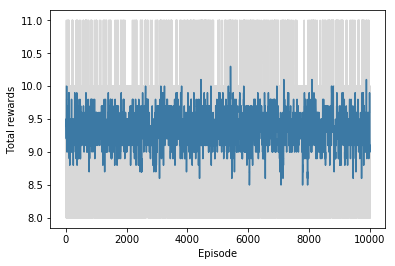

In [31]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

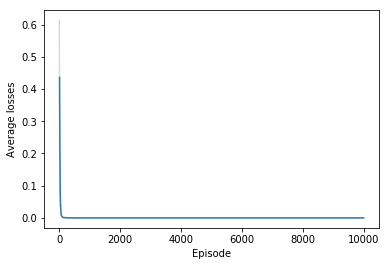

In [32]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for each_episode in range(1):

        # Start a new episode/epoch
        state = env.reset()
        
        # Rendering the env graphics
        env.render()

        # Steps/batches
        for each_step in range(111111111111111111):
                        
            # Calculating next action using OLD memory
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            #reward = 1 - float(done)
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-pg.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.